# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [0]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

In [2]:
from google.colab import drive
drive.mount('/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /gdrive


In [3]:
# using SQLite Table to read data.
con = sqlite3.connect('/gdrive/My Drive/Colab Notebooks/database.sqlite') 

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 
# for tsne assignment you can take 5k data points

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (500000, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [0]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [5]:
print(display.shape)
display.head()

(80668, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B007Y59HVM,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ET0,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B007Y59HVM,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ET0,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBE1U,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


In [6]:
display[display['UserId']=='AZY10LLTJ71NX']

,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
80638,AZY10LLTJ71NX,B006P7E5ZI,"undertheshrine ""undertheshrine""",1334707200,5,I was recommended to try green tea extract to ...,5


In [7]:
display['COUNT(*)'].sum()

393063

#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [8]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [0]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [10]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(348262, 10)

In [11]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

69.6524

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [12]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [0]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [14]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(348260, 10)


1    293516
0     54744
Name: Score, dtype: int64

#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [15]:
# printing some random reviews
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final['Text'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = final['Text'].values[4900]
print(sent_4900)
print("="*50)

This book was purchased as a birthday gift for a 4 year old boy. He squealed with delight and hugged it when told it was his to keep and he did not have to return it to the library.
I've purchased both the Espressione Espresso (classic) and the 100% Arabica.  My vote is definitely with the 100% Arabica.  The flavor has more bite and flavor (much more like European coffee than American).
This is a great product. It is very healthy for all of our dogs, and it is the first food that they all love to eat. It helped my older dog lose weight and my 10 year old lab gain the weight he needed to be healthy.
I find everything I need at Amazon so I always look there first. Chocolate tennis balls for a tennis party, perfect! They were the size of malted milk balls. Unfortunately, they arrived 3 days after the party. The caveat here is, not everything from Amazon may arrive at an impressive 2 or 3 days. This shipment took 8 days from the Candy/Cosmetic Depot back east to southern California.


In [16]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_0)

This book was purchased as a birthday gift for a 4 year old boy. He squealed with delight and hugged it when told it was his to keep and he did not have to return it to the library.


In [17]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_4900, 'lxml')
text = soup.get_text()
print(text)

This book was purchased as a birthday gift for a 4 year old boy. He squealed with delight and hugged it when told it was his to keep and he did not have to return it to the library.
I've purchased both the Espressione Espresso (classic) and the 100% Arabica.  My vote is definitely with the 100% Arabica.  The flavor has more bite and flavor (much more like European coffee than American).
This is a great product. It is very healthy for all of our dogs, and it is the first food that they all love to eat. It helped my older dog lose weight and my 10 year old lab gain the weight he needed to be healthy.
I find everything I need at Amazon so I always look there first. Chocolate tennis balls for a tennis party, perfect! They were the size of malted milk balls. Unfortunately, they arrived 3 days after the party. The caveat here is, not everything from Amazon may arrive at an impressive 2 or 3 days. This shipment took 8 days from the Candy/Cosmetic Depot back east to southern California.


In [0]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [19]:
sent_1500 = decontracted(sent_1500)
print(sent_1500)
print("="*50)

This is a great product. It is very healthy for all of our dogs, and it is the first food that they all love to eat. It helped my older dog lose weight and my 10 year old lab gain the weight he needed to be healthy.


In [20]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

This book was purchased as a birthday gift for a  year old boy. He squealed with delight and hugged it when told it was his to keep and he did not have to return it to the library.


In [21]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)
print(sent_1500)

This is a great product It is very healthy for all of our dogs and it is the first food that they all love to eat It helped my older dog lose weight and my 10 year old lab gain the weight he needed to be healthy 


In [0]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [23]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|██████████| 348260/348260 [02:13<00:00, 2608.73it/s]


In [24]:
preprocessed_reviews[1500]

'great product healthy dogs first food love eat helped older dog lose weight year old lab gain weight needed healthy'

<h2><font color='red'>[3.2] Preprocessing Review Summary</font></h2>

In [0]:
## Similartly you can do preprocessing for review summary also.

final["preprocessed_reviews"] = preprocessed_reviews

In [26]:
final.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,preprocessed_reviews
138702,150520,0006641040,ADBFSA9KTQANE,"James L. Hammock ""Pucks Buddy""",0,0,1,1256688000,Great Gift,This book was purchased as a birthday gift for...,book purchased birthday gift year old boy sque...
138707,150525,0006641040,A2QID6VCFTY51R,Rick,1,2,1,1025481600,"In December it will be, my snowman's anniversa...","My daughter loves all the ""Really Rosie"" books...",daughter loves really rosie books introduced r...
138708,150526,0006641040,A3E9QZFE9KXH8J,R. Mitchell,11,18,0,1129507200,awesome book poor size,This is one of the best children's books ever ...,one best children books ever written mini vers...
138692,150510,0006641040,AM1MNZMYMS7D8,Dr. Joshua Grossman,0,0,1,1348358400,Professional Mentoring,TITLE: Chicken Soup with Rice<br />AUTHOR: Mau...,title chicken soup riceauthor maurice sendakre...
138689,150507,0006641040,A1S4A3IQ2MU7V4,"sally sue ""sally sue""",1,1,1,1191456000,chicken soup with rice months,This is a fun way for children to learn their ...,fun way children learn months year learn poems...


In [0]:
final=final.drop(["Id","ProductId","UserId","ProfileName","HelpfulnessNumerator"],axis=1)

In [0]:
final_last=final.drop(["HelpfulnessDenominator","Time","Summary","Text"],axis=1)

In [29]:
final_last.shape

(348260, 2)

In [30]:
final_last.head()

,Score,preprocessed_reviews
138702,1,book purchased birthday gift year old boy sque...
138707,1,daughter loves really rosie books introduced r...
138708,0,one best children books ever written mini vers...
138692,1,title chicken soup riceauthor maurice sendakre...
138689,1,fun way children learn months year learn poems...


# [4] Featurization

In [0]:
X = final_last["preprocessed_reviews"]

Y = final_last["Score"]

In [32]:
X.head()

138702    book purchased birthday gift year old boy sque...
138707    daughter loves really rosie books introduced r...
138708    one best children books ever written mini vers...
138692    title chicken soup riceauthor maurice sendakre...
138689    fun way children learn months year learn poems...
Name: preprocessed_reviews, dtype: object

## [4.3] TF-IDF

In [33]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=10)
tf_idf_vect.fit(X)
print("some sample features(unique words in the corpus)",tf_idf_vect.get_feature_names()[0:10])
print('='*50)

final_tf_idf = tf_idf_vect.transform(X)
print("the type of count vectorizer ",type(final_tf_idf))
print("the shape of out text TFIDF vectorizer ",final_tf_idf.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_tf_idf.get_shape()[1])

some sample features(unique words in the corpus) ['aa', 'aaa', 'aaaaa', 'aaah', 'aafco', 'ab', 'aback', 'abandon', 'abandoned', 'abbey']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (348260, 194764)
the number of unique words including both unigrams and bigrams  194764


# [5] Assignment 11: Truncated SVD

<ol>
    <li><strong>Apply Truncated-SVD on only this feature set:</strong>
        <ul>
            <li><font color='red'>SET 2:</font>Review text, preprocessed one converted into vectors using (TFIDF)</li>
    <br>
    <li><strong>Procedure:</strong>
        <ul>
    <li>Take top 2000 or 3000 features from tf-idf vectorizers using idf_ score.</li>
    <li>You need to calculate the co-occurrence matrix with the selected features (Note: X.X^T
doesn’t give the co-occurrence matrix, it returns the covariance matrix, check these
        bolgs <a href='https://medium.com/data-science-group-iitr/word-embedding-2d05d270b285'>blog-1,</a> <a href='https://www.analyticsvidhya.com/blog/2017/06/word-embeddings-count-word2veec/'>blog-2 </a>for more information)</li>
            <li>You should choose the n_components in truncated svd, with maximum explained
variance. Please search on how to choose that and implement them. (hint: plot of
cumulative explained variance ratio)</li>
            <li>After you are done with the truncated svd, you can apply K-Means clustering and choose
the best number of clusters based on elbow method.</li>
            <li> Print out wordclouds for each cluster, similar to that in previous assignment. </li>
            <li>You need to write a function that takes a word and returns the most similar words using
cosine similarity between the vectors(vector: a row in the matrix after truncatedSVD)</li>
        </ul>
    </li>
    <br>
    
</ol>

## Truncated-SVD

### [5.1] Taking top features from TFIDF,<font color='red'> SET 2</font>

In [0]:
# Please write all the code with proper documentation
tfidf_top_2000 = pd.DataFrame({"Feature Name": tf_idf_vect.get_feature_names() ,"Coefficients": np.transpose(tf_idf_vect.idf_) })

In [0]:
tfidf_top_2000 = tfidf_top_2000.sort_values(by = 'Coefficients' ,ascending=True)

In [0]:
tfidf_top_2000 = tfidf_top_2000.reset_index()

In [0]:
tfidf_top_2000 = tfidf_top_2000.drop("index",axis = 1)

In [0]:
tfidf_top_2000 = tfidf_top_2000[:2000] # taking top 2000 features from TFIDF.

In [0]:
columnsTitles=["Feature Name","Coefficients"]
tfidf_top_2000=tfidf_top_2000.reindex(columns=columnsTitles)

In [40]:
tfidf_top_2000.head(10)

,Feature Name,Coefficients
0,not,1.613387
1,like,2.233189
2,good,2.333013
3,great,2.414829
4,one,2.521798
5,taste,2.524221
6,product,2.614637
7,would,2.621647
8,love,2.695946
9,flavor,2.715389


### [5.2] Calulation of Co-occurrence matrix

In [41]:
#Reference : https://github.com/saugatapaul1010/Amazon-Fine-Food-Reviews-Analysis/blob/master/16.%20%20Truncated%20SVD.ipynb
#Generate the Co-Occurence Matrix
def get_coOccuranceMatrix(X, top_features, window): #window = 5 means 5 on either side of the given word. Lets look at an example. data = [a,b,c,d,e,f,g,h,i,j,k],
    print("Generating the Co Occurence Matrix....")       #if window = 5, for letter f, we will have neighborhood = [a,b,c,d,e,g,h,i,j,k].
    dim=top_features.shape[0]
    square_matrix = np.zeros((dim,dim),int)
    
    values = [i for i in range(0,top_features.shape[0])]  #Contains all the top TF-IDF Scores as values.
    keys = [str(i) for i in top_features['Feature Name']]    #Contains all the corresponding features names as keys.
    lookup_dict = dict(zip(keys,values))                  #We will use this dictionary as a look up table 

    top_words= keys
    
    #Processing each reviews to build the co-occurence Matrix
    for reviews in tqdm(X):
        #Split each review into words
        words = reviews.split()
        lnt = len(words)
        for i in range(0,len(words),1):
            idx_of_neigbors= []
            if((i-window >= 0) and (i+window < lnt)):
                idx_of_neigbors = np.arange(i-window,i+window+1)
            elif((i-window < 0) and (i+window < lnt)): 
                idx_of_neigbors = np.arange(0, i+window+1)
            elif((i-window >= 0) and (i+window >= lnt)):
                idx_of_neigbors = np.arange(i-window, lnt)
            else:
                pass
            #nei = [words[x] for x in idx_of_neigbors]
            #print(words[i],"---------",nei)
            #print(idx_of_neigbors)
            
            for j in idx_of_neigbors:
                if((words[j] in top_words) and (words[i] in top_words)):
                    row_idx = lookup_dict[words[i]]     #Get the index of the ith word from the lookup table
                    col_idx = lookup_dict[words[j]]     #Get the index of the jth word from the lookup table
                    square_matrix[row_idx,col_idx] += 1 #If word[i] and word[j] occurs in a neighbourhood of 5, there co occurence will be increases by one.
                else:
                    pass
                    
    #Fill all the diagonal elements of the co-occurence matrix with 0, as co-occurence of a word with itlself is always zero.                
    np.fill_diagonal(square_matrix, 0) 
    print("Co Occurence Matrix is generated....")      
    
    #Create a co-occurence dataframe.
    co_occur_df=pd.DataFrame(data=square_matrix, index=keys, columns=keys)
    return co_occur_df

co_occur_matrix = get_coOccuranceMatrix(X, tfidf_top_2000, window=5)

#Save the co occurence matrix.
co_occur_matrix.to_csv('cooccurence.csv')

  0%|          | 14/348260 [00:00<42:14, 137.38it/s]

Generating the Co Occurence Matrix....


100%|██████████| 348260/348260 [48:52<00:00, 118.78it/s]


Co Occurence Matrix is generated....


In [42]:
co_occur_matrix

,not,like,good,great,one,taste,product,would,love,flavor,get,no,really,amazon,much,also,time,use,best,buy,find,little,price,tried,well,make,even,coffee,better,try,food,first,eat,could,tea,used,found,bought,made,way,...,delight,no way,consistent,loss,fry,love love,fully,experienced,exactly like,coffee drinker,inexpensive,trader,wonderfully,ingredient list,crushed,im,sunflower,friendly,overly sweet,packing,equal,exception,give stars,gallon,price good,water not,like tea,shows,claims,brings,guys,unpleasant,runs,hard time,filter,available amazon,power,nutrients,german,expectations
not,0,55843,33975,19124,24659,38499,23496,32044,13839,26044,20400,10886,19196,12124,19479,11599,11097,12332,8127,14888,15170,9328,9986,11829,10643,11121,17281,21909,8977,10827,14963,7542,14433,17302,17898,7013,7253,5371,6865,6816,...,179,0,285,313,195,0,345,340,0,0,276,238,194,0,279,327,223,257,0,236,340,228,0,188,0,0,0,259,375,149,281,542,184,0,305,0,262,272,159,375
like,55854,0,11651,7303,9782,23423,7083,11599,5833,11704,5423,5714,11963,2469,7503,6312,3237,4268,3652,3625,3282,5638,2472,4348,3823,4169,4853,12914,4686,4776,5844,2812,3913,2310,9658,2794,2144,1810,2833,2865,...,62,0,78,48,138,0,83,81,0,0,76,97,91,0,99,123,166,89,0,76,94,115,0,90,0,0,0,83,86,61,109,155,92,0,113,0,98,75,81,70
good,33995,11662,0,6918,7320,14930,9029,7664,4451,9685,4854,4468,10689,3790,3440,5775,3672,3470,2688,4027,3630,3871,8148,3139,3948,3945,3481,9274,3504,3227,4288,1876,3241,2243,7372,2042,2396,1908,2462,2590,...,68,0,124,65,87,0,50,56,0,0,135,73,51,0,77,124,91,74,0,105,49,105,0,67,0,0,0,47,77,75,90,56,44,0,65,0,57,117,80,84
great,19162,7320,6928,0,4908,12655,12987,5098,6356,9186,4118,4008,4735,5083,2781,5243,3303,4166,2330,3610,3200,3488,9244,1964,3407,4122,2706,7585,2202,2171,3286,1346,2114,1374,6067,1953,1876,1416,1901,3010,...,59,0,72,89,112,0,39,51,0,0,112,49,83,0,52,80,79,81,0,108,53,89,0,75,0,0,0,43,37,105,98,32,83,0,71,0,88,96,63,84
one,24655,9774,7318,4897,0,5651,4192,6631,4340,5307,4863,4902,3824,2813,3265,2979,4785,3570,5929,3249,2904,3270,2393,5160,2525,3134,2968,5693,2742,3913,3568,2925,4431,2728,5065,2032,2647,2501,1991,1782,...,83,0,73,66,36,0,66,74,0,0,45,73,45,0,100,90,40,54,0,72,130,218,0,161,0,0,0,93,76,65,94,65,96,0,74,0,82,36,62,60
taste,38503,23429,14922,12644,5659,0,5115,6492,5857,6960,3864,6641,6759,1301,4705,3558,1962,2866,2871,2239,2313,3996,2095,3070,3012,2922,3662,7883,4707,2347,2171,2436,1878,2915,6593,2142,2056,1244,1906,2007,...,112,0,144,52,61,0,54,97,0,0,42,58,102,0,43,71,126,63,0,42,102,109,0,52,0,0,0,47,70,108,46,353,30,0,58,0,60,66,44,120
product,23511,7090,9039,12995,4199,5121,0,7571,5425,3026,3105,4372,3637,5693,3189,2501,3450,4276,2254,4132,3596,1902,4970,2178,2881,2240,2046,2051,2261,2248,2391,2303,1276,2088,1841,2830,2690,2134,2267,1633,...,63,0,135,81,38,0,86,83,0,0,101,64,56,0,49,92,47,88,0,124,85,70,0,45,0,0,0,131,194,53,54,36,46,0,33,0,48,65,47,189
would,32036,11603,7652,5096,6632,6487,7563,0,3323,4724,4633,3215,3289,2894,3818,2610,2962,3466,1523,7318,2313,3007,3278,2070,2781,3849,3391,4670,3387,4589,3757,1903,4694,2950,3779,1467,1314,1768,1743,1861,...,49,0,45,51,49,0,62,43,0,0,55,62,40,0,59,48,59,71,0,94,80,35,0,94,0,0,0,32,69,32,64,63,53,0,53,0,54,46,45,97
love,13887,5839,4470,6368,4349,5877,5428,3330,0,5334,2850,2352,3437,2747,3128,2741,1991,2526,2318,2319,2244,2238,1952,1961,1770,1899,1954,5809,1377,2411,3294,1475,2116,1044,6123,1347,1398,1319,1096,1245,...,53,0,28,21,44,0,22,28,0,0,55,51,42,0,25,98,91,53,0,27,25,73,0,49,0,0,0,24,16,76,104,7,33,0,23,0,39,28,80,28
flavor,26040,11702,9669,9159,5303,6956,3019,4723,5318,0,3259,4570,5172,1283,4221,3401,1998,2873,3142,1909,2353,3917,1593,3060,2693,2009,2502,7743,2674,2388,1334,1487,1202,1658,7415,1785,1710,1058,1203,1571,...,83,0,164,65,68,0,55,77,0,0,44,39,120,0,40,34,72,46,0,25,67,90,0,33,0,0,0,43,48,218,31,157,35,0,29,0,54,54,33,83


### [5.3] Finding optimal value for number of components (n) to be retained.

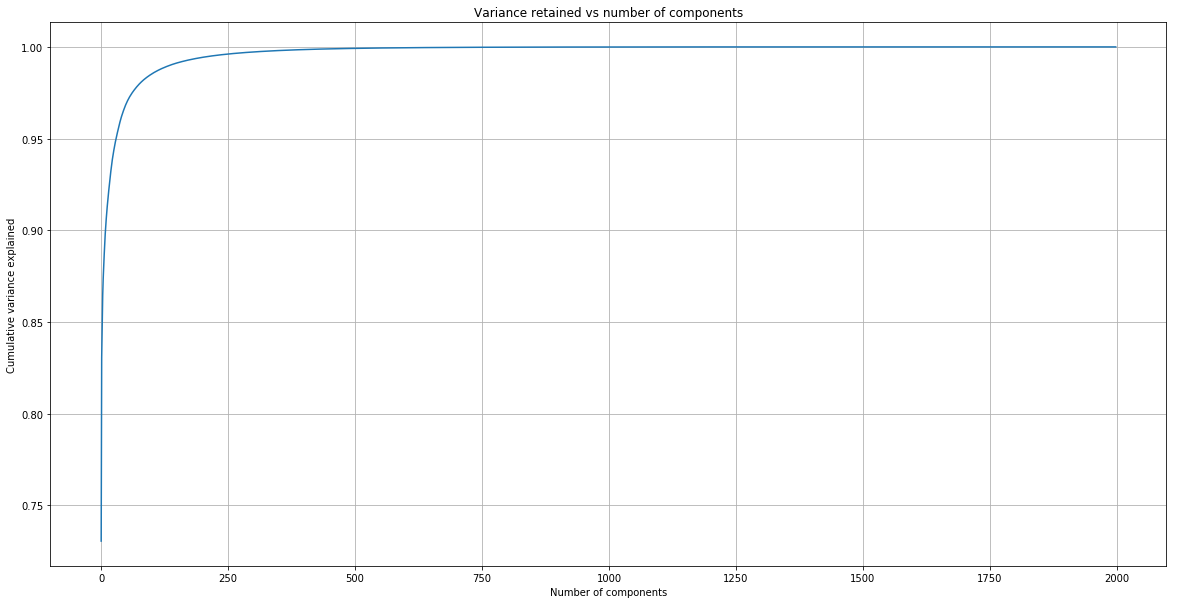

In [43]:
# Please write all the code with proper documentation

from sklearn.decomposition import TruncatedSVD

svd_model = TruncatedSVD(n_components = 1999,
                        algorithm = 'randomized',
                        n_iter = 10,
                        random_state = 0)

svd_fit = svd_model.fit_transform(co_occur_matrix)

cum_var_explained = np.cumsum(svd_model.explained_variance_ratio_)

plt.figure(1 , figsize = (20,10))
plt.plot(cum_var_explained)
plt.grid()
plt.title("Variance retained vs number of components")
plt.xlabel("Number of components")
plt.ylabel("Cumulative variance explained")
plt.show()

#### As we can see that ,if we use number of components = 500 then almost 100% variance is retained ,so we can use n_component = 500

### [5.4] Applying k-means clustering

In [44]:
n_components = 500

svd_model = TruncatedSVD(n_components = n_components , n_iter = 0)

U = svd_model.fit_transform(co_occur_matrix)
VT = svd_model.components_
Sigma = np.zeros((n_components , n_components),int)
np.fill_diagonal(Sigma , svd_model.singular_values_)

print("U = {} ,Sigma = {} ,VT = {}".format(U.shape , Sigma.shape , VT.shape))#MF Formulae for SVD : X = U * sigma * V.T 
#=> U contains <u1,u2,u3...ud> -> Word vectors corresponding to the top words

U = (2000, 500) ,Sigma = (500, 500) ,VT = (500, 2000)


In [0]:
#choose the best number of clusters based on elbow method

from sklearn.cluster import KMeans

sse_df = pd.DataFrame(columns = ['K' ,'SSE'])

for i in range(2 ,11):
    km = KMeans(n_clusters = i ,max_iter = 100 , n_init = 10)
    km.fit(U)
    sse_df.loc[sse_df.shape[0]] = [i , km.inertia_]

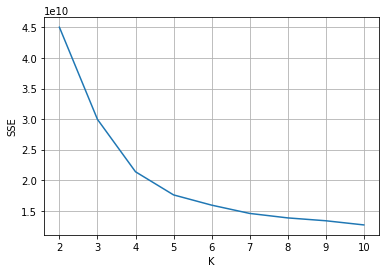

In [46]:

plt.grid()
sns.lineplot(x = 'K' , y = 'SSE' ,data = sse_df)

### by looking into above elbow plot we are taking optimal value of k = 6

In [49]:
#lets again try to build kmeans model with n_clusters = 6

km_model_5 = KMeans(n_clusters = 5 ,max_iter = 100)

km_model_5.fit(U)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=100,
    n_clusters=5, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [0]:
km_model_predict = km_model_5.predict(U)

### [5.5] Wordclouds of clusters obtained in the above section

In [0]:
index_1 = []
index_2 = []
index_3 = []
index_4 = []
index_5 = []
for i in range(len(km_model_predict)):
    if km_model_predict[i] == 0:
        index_1.append(i)
    if km_model_predict[i] == 1:
        index_2.append(i)
    if km_model_predict[i] == 2:
        index_3.append(i)
    if km_model_predict[i] == 3:
        index_4.append(i)
    if km_model_predict[i] == 4:
        index_5.append(i)
        

1474


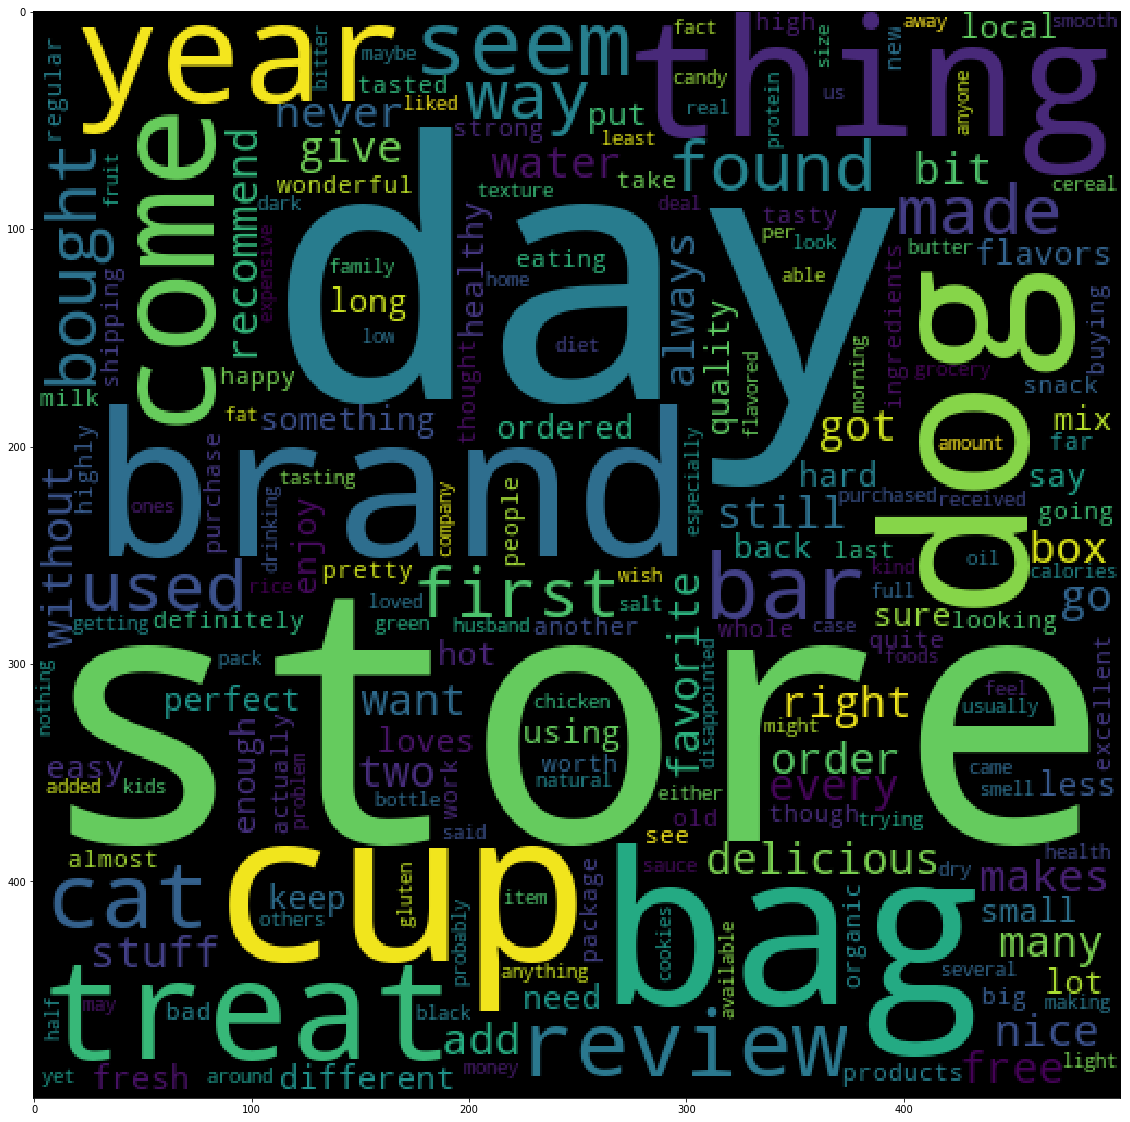

In [53]:
# Please write all the code with proper documentation
from wordcloud import WordCloud
top_feats = [str(i) for i in tfidf_top_2000["Feature Name"]]

text_1 = []
for i in range(len(index_1)):
    text_1.append(top_feats[index_1[i]])
    
words_1 = ''
for word in text_1:
    words_1 = words_1 + ' ' + word 

print(len(words_1))

wordcloud = WordCloud(background_color = 'black',
                     width = 500,
                     height = 500,
                     ).generate(str(words_1))

fig = plt.figure(figsize = (30,20))
plt.imshow(wordcloud)

54


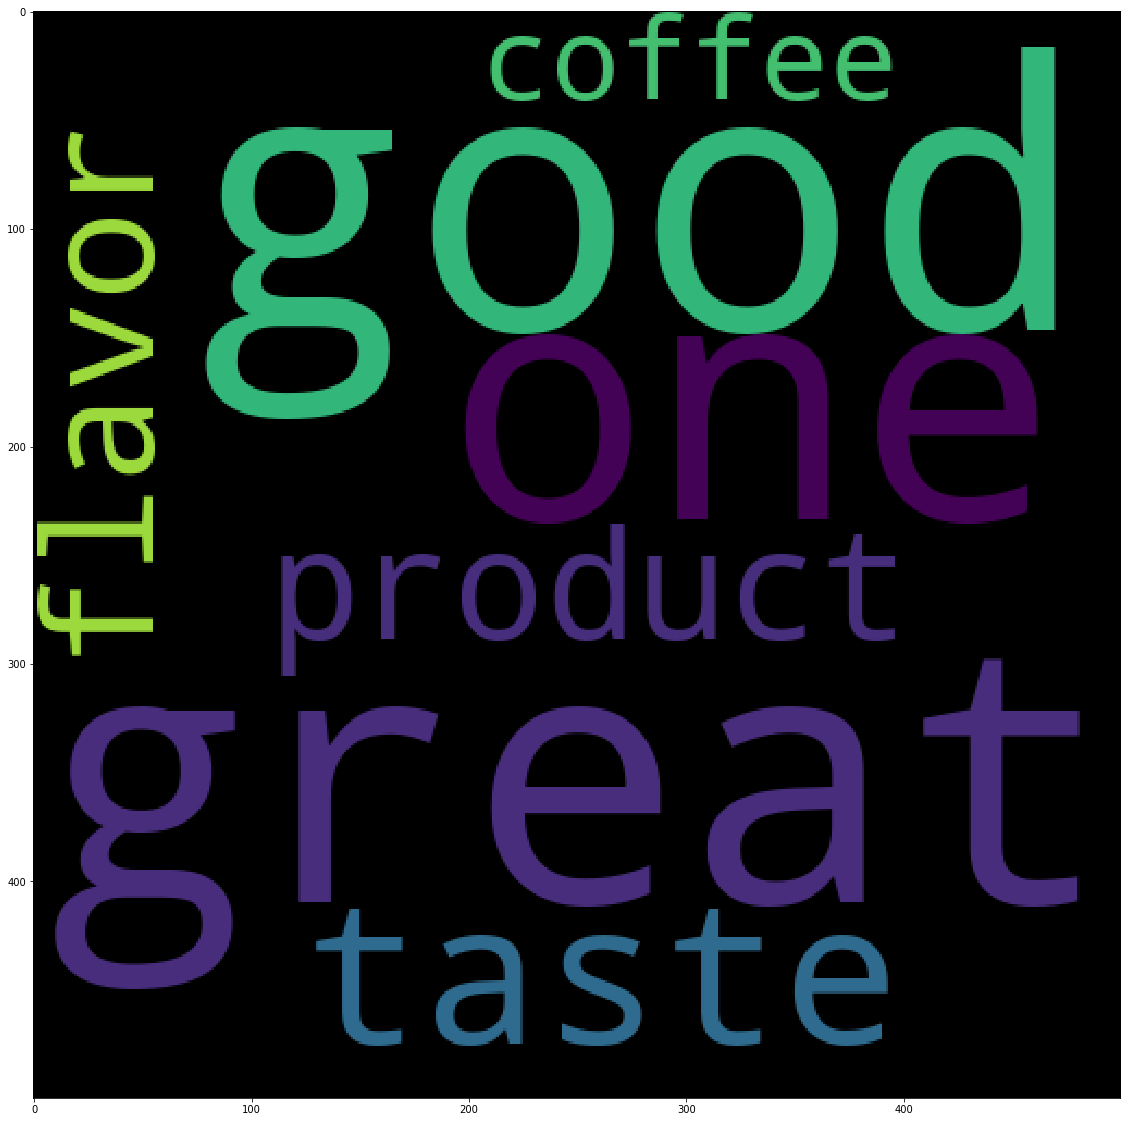

In [58]:
# Please write all the code with proper documentation

top_feats = [str(i) for i in tfidf_top_2000["Feature Name"]]

text_2 = []
for i in range(len(index_2)):
    text_2.append(top_feats[index_2[i]])
    
words_2 = ''
for word in text_2:
    words_2 = words_2 + ' ' + word 

print(len(words_2))

wordcloud = WordCloud(background_color = 'black',
                     width = 500,
                     height = 500,
                     ).generate(str(words_2))

fig = plt.figure(figsize = (30,20))
plt.imshow(wordcloud)

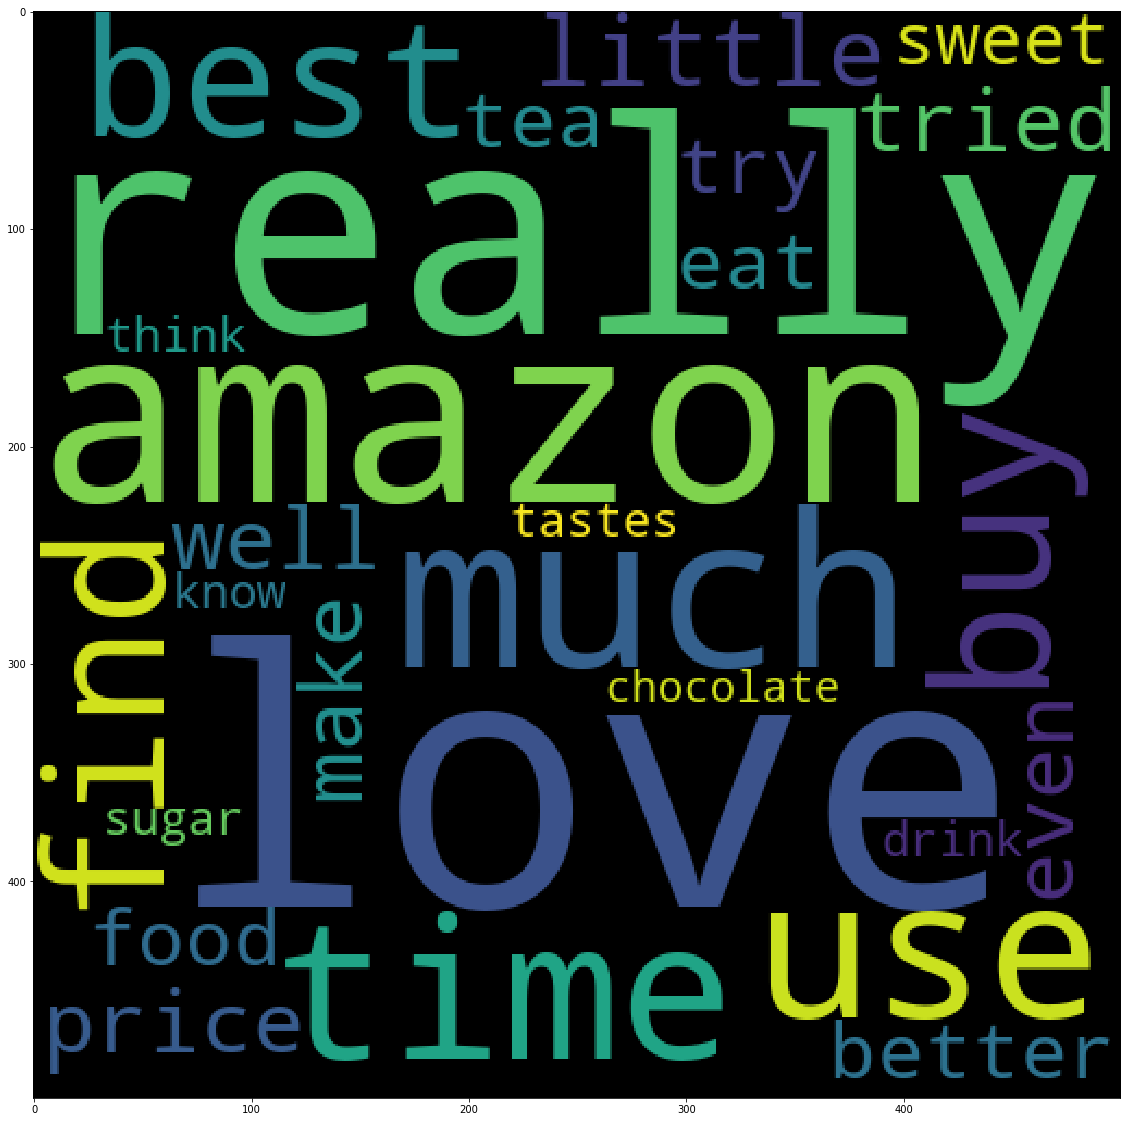

In [55]:
# Please write all the code with proper documentation

text_4 = []
for i in range(len(index_4)):
    text_4.append(top_feats[index_4[i]])
    
words_4 = ''
for word in text_4:
    words_4 = words_4 + ' ' + word 


wordcloud = WordCloud(background_color = 'black',
                     width = 500,
                     height = 500,
                     ).generate(str(words_4))

fig = plt.figure(figsize = (30,20))
plt.imshow(wordcloud)

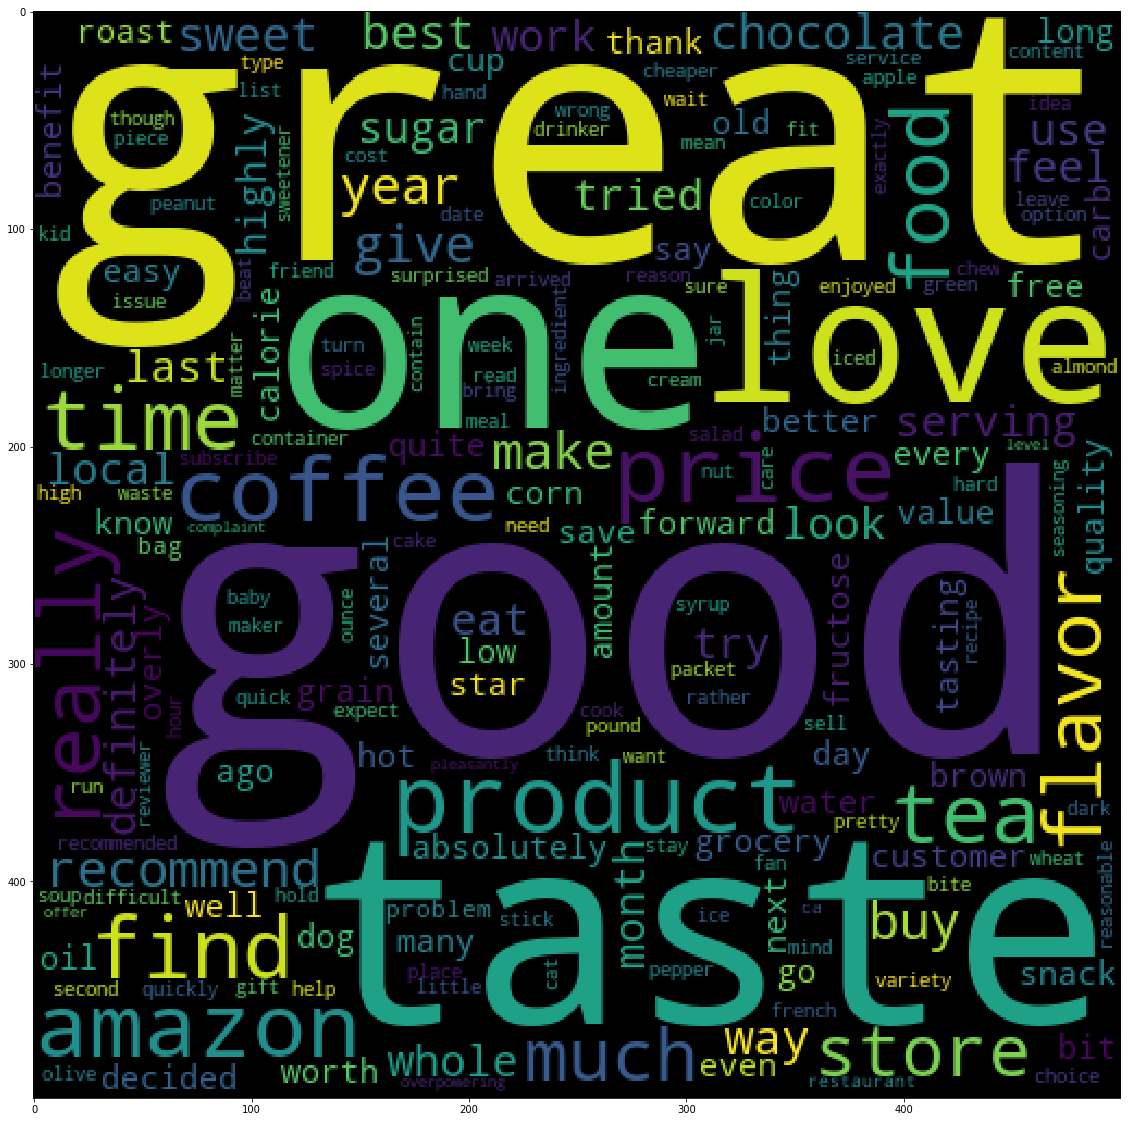

In [56]:
# Please write all the code with proper documentation

text_5 = []
for i in range(len(index_5)):
    text_5.append(top_feats[index_5[i]])
    
words_5 = ''
for word in text_5:
    words_5 = words_5 + ' ' + word 


wordcloud = WordCloud(background_color = 'black',
                     width = 500,
                     height = 500,
                     ).generate(str(words_5))

fig = plt.figure(figsize = (30,20))
plt.imshow(wordcloud)

### [5.6] Function that returns most similar words for a given word.

In [0]:
#Reference : https://github.com/saugatapaul1010/Amazon-Fine-Food-Reviews-Analysis/blob/master/16.%20%20Truncated%20SVD.ipynb
# Please write all the code with proper documentation
from numpy import dot
from numpy.linalg import norm
#Function to obtain cosine distance between any two vectors

def cosine_sim(data_point_1 ,data_point_2):
    cosine_dis = dot(data_point_1 ,data_point_2)/(norm(data_point_1)*norm(data_point_2))
    return (1 - cosine_dis)


In [0]:

from nltk.stem.snowball import SnowballStemmer
def get_nearest_words(U , tfidf_top_2000 ,data_point):
    print("words related to {}".format(data_point))
    data_point = data_point.lower()
    top_2000 = list(tfidf_top_2000["Feature Name"])
    if data_point in top_2000:
        for i in range(len(top_2000)):
            if data_point == top_2000[i]:
                index = i
        
        
        similarity_values = []
        for i in range(U.shape[0]):
            similarity_values.append(cosine_sim(U[i], U[index]))
        
        sorted_indexes = np.array(similarity_values).argsort()
        
        #Display top 10 nearest words to the data_point
        sim_words = []
        sim_scores = []
        for i in range(1,11):
            sim_words.append(top_2000[sorted_indexes[i]])
            sim_scores.append(1 - similarity_values[sorted_indexes[i]])
        
        
        from prettytable import PrettyTable
        table = PrettyTable()
        
        table.add_column("Similar Words" ,sim_words)
        table.add_column("Similarity Scores" ,sim_scores)
        print(table)

In [61]:
get_nearest_words(U,tfidf_top_2000,"meat")

words related to meat
+---------------+--------------------+
| Similar Words | Similarity Scores  |
+---------------+--------------------+
|      fish     | 0.9212064090780018 |
|      etc      | 0.9048392664741313 |
|    chicken    | 0.9030952700903592 |
|     gravy     | 0.8965101980562312 |
|      soup     | 0.8889574567214484 |
|     cooked    | 0.8859791453930094 |
|   vegetables  | 0.8857876446953719 |
|     course    | 0.8822048188874755 |
|    noodles    | 0.8787596619299277 |
|     mostly    | 0.8782761316222412 |
+---------------+--------------------+


# [6] Conclusions

we almost retain almost 100% of variance explianed by reducing number of components from 2000 to 500.

after reducing number of number of componets from **2000 to 500** ,we applied Kmeans algo on reduced number of components and find the
optimal number of **n_clusters i.e 6** using elbow method

After finding optimal number of k we again applied Kmeans clustering technique to obtain 6 clusters.
on these 6 clusters we applied wordcloud to get the gist of these clusters. these 6 clusters are not robust as they dont convey any meaning.
we can improve this technique using more number of data.

After that we calculated cosine similarity between words and obtain **10 most similar words** to a particular word.